<a href="https://colab.research.google.com/github/Sokratis1000/time-series-forcasting/blob/master/2000's_including_economic_features_as_known_variable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_lightning
!pip install pytorch_forecasting

     |████████████████████████████████| 584 kB 18.9 MB/s 
     |████████████████████████████████| 596 kB 47.4 MB/s 
     |████████████████████████████████| 136 kB 49.3 MB/s 
     |████████████████████████████████| 409 kB 62.6 MB/s 
     |████████████████████████████████| 1.1 MB 49.6 MB/s 
     |████████████████████████████████| 144 kB 58.2 MB/s 
     |████████████████████████████████| 94 kB 1.6 MB/s 
     |████████████████████████████████| 271 kB 51.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 127 kB 14.4 MB/s 
     |████████████████████████████████| 308 kB 51.3 MB/s 
     |████████████████████████████████| 210 kB 42.8 MB/s 
     |████████████████████████████████| 81 kB 12.2 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 146 kB 67.6 MB/s 
     |████████████████████████████████| 112 

In [ ]:
#https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import copy


import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving From_2000.csv to From_2000.csv


In [ ]:
import pandas as pd
import io
data = pd.read_csv(io.BytesIO(data_to_load['From_2000.csv']),encoding = "ISO-8859-1")

In [ ]:
data['Date']=pd.to_datetime(data['Date'])

In [ ]:
# add time index
data["time_idx"] = data["Date"].dt.year * 12 + data["Date"].dt.month
data["time_idx"] -= data["time_idx"].min()
# add additional features
data["month"] = data.Date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_Construction_Employment_State"] = np.log(data.Construction_Employment_State + 1e-8)
data["avg_volume_by_state"] = data.groupby(["time_idx", "State"], observed=True).Construction_Employment_State.transform("mean")



#we want to encode special days as one variable and thus need to first reverse one-hot encoding
Extreme_Events=[
"Recession",
]
data[Extreme_Events] = data[Extreme_Events].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,State,Date,Construction_Employment_State,Coincident_Economic_Activity_State,Labor_Force_Participation_State,Permits_Housing_State,Unemployment_Rate_State,Property_Damage_State,Construction_Employment_US,PPI_Machinary_US,...,Dist_Vermont,Dist_Virginia,Dist_Washington,Dist_WestVirginia,Dist_Wisconsin,Dist_Wyoming,time_idx,month,log_Construction_Employment_State,avg_volume_by_state
738,Rhode Island,2002-03-01,20.3,91.18,66.0,188.72,4.8,0,6755,151.2,...,177.82,5762.82,2162.61,513.95,736.08,1495.30,14,3,3.010621,20.3
7339,South Carolina,2013-03-01,79.9,109.40,59.6,1383.77,8.1,12000000,5802,210.0,...,769.77,6420.90,2107.67,344.59,723.96,1290.61,146,3,4.380776,79.9
11164,Iowa,2019-08-01,78.9,126.15,70.6,839.85,2.7,0,7527,232.7,...,910.78,6069.83,1272.54,585.01,266.79,505.52,223,8,4.368181,78.9
6214,Iowa,2011-05-01,61.8,100.55,70.3,476.04,5.7,15000000,5516,196.1,...,910.78,6069.83,1272.54,585.01,266.79,505.52,124,5,4.123903,61.8
11051,Alaska,2019-06-01,16.4,112.13,64.8,86.23,5.5,3000000,7510,232.4,...,2772.12,4513.07,1248.13,2817.49,2416.53,2021.20,221,6,2.797281,16.4
6152,Arizona,2011-04-01,108.7,99.56,62.2,817.75,9.6,100000,5485,195.6,...,1911.95,6569.67,969.42,1503.64,1269.96,577.26,123,4,4.688592,108.7
3203,Arkansas,2006-05-01,57.1,98.03,62.9,735.94,5.3,0,7713,175.3,...,1057.31,6466.99,1548.08,559.90,539.92,705.02,64,5,4.044804,57.1
8429,New Jersey,2015-01-01,144.3,110.85,64.3,848.73,6.3,0,6320,216.6,...,229.47,5874.98,2082.47,374.04,631.37,1384.64,168,1,4.971894,144.3
7815,Kansas,2014-01-01,60.2,110.65,68.1,382.47,4.8,0,5985,213.0,...,1161.37,6323.52,1247.59,743.74,536.65,404.47,156,1,4.097672,60.2
4743,Utah,2008-11-01,83.6,101.95,70.7,596.06,3.6,0,6813,189.9,...,1709.10,6134.82,609.35,1402.46,1075.91,321.51,94,11,4.426044,83.6


In [ ]:

max_prediction_length = 6
max_encoder_length = 24
#min_prediction_idx=300
training_cutoff = data["time_idx"].max() - max_prediction_length
validation_start=data["time_idx"].max() - max_prediction_length - max_encoder_length
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Construction_Employment_State",
    group_ids=["State"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["State"],
    static_reals=["Dist_Alabama","Dist_Alaska","Dist_Arkansas","Dist_California","Dist_Colorado","Dist_Connecticut","Dist_Delaware","Dist_Florida","Dist_Georgia","Dist_Hawaii","Dist_Idaho","Dist_Illinois","Dist_Indiana","Dist_Kansas","Dist_Kentucky","Dist_Louisiana","Dist_Maine","Dist_Maryland","Dist_Massachusetts","Dist_Michigan","Dist_Minnesota","Dist_Mississippi","Dist_Missouri","Dist_Montana","Dist_Nebraska","Dist_NewHampshire","Dist_Nevada","Dist_NewJersey","Dist_NewMexico","Dist_NewYork","Dist_NorthCarolina","Dist_NorthDakota","Dist_Ohio","Dist_Oklahoma","Dist_Oregon","Dist_Pennsylvania","Dist_RhodeIsland","Dist_SouthCarolina","Dist_SouthDakota","Dist_Tennessee","Dist_Texas","Dist_Utah","Dist_Vermont","Dist_Virginia","Dist_Washington","Dist_WestVirginia","Dist_Wisconsin","Dist_Wyoming"],
    #min_prediction_idx=min_prediction_idx,
    time_varying_known_categoricals=["month"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["Extreme_Events"],
    variable_groups={"Extreme_Events": Extreme_Events},  # group of categorical variables can be treated as one variable
    #time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["Construction_Employment_State","Coincident_Economic_Activity_State",
        "Labor_Force_Participation_State",
        "Permits_Housing_State",
        "Unemployment_Rate_State",
        "Property_Damage_State",
        "Construction_Employment_US",
        "PPI_Machinary_US",
        "PPI_Material_US ",
        "CPI_US",
        "Labor_Force_Participation_US",
        "FFER_US",
        "New_Hires_US",
        "Job_Openings_Construction_US",
        "Layoffs_Construction_US",
        "Separations_Construction_US",
        "New_Privately_Owned_Houses_US",
        "Unemployment_Rate_US",
        "Hourly_Earning_US",
        "CCI_US",
        "BCI_US",
        "MPI_US",
        "Construction_Spending_Total_US",
        "Construction_Spending_Private_US",
        "Construction_Spending_Public_US",
        "Total_Tax_Recipt",
        "Ind_Income_Tax ",
        "Corporate_Tax",
        "Wages_Tax",
        "Income_Security ",
    ],

    target_normalizer=GroupNormalizer(
        groups=["State"],transformation="softplus"
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,

)
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, data[lambda x:x.time_idx > validation_start], predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
print(type(val_dataloader))



<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


1.8803339004516602

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore the

Number of parameters in network: 75.4k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/.lr_find_680ea10b-80a8-4fb7-92bd-f08c37b0b168.ckpt
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1719: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': None}"].
  "Be aware that when using `ckpt_path`,"


suggested learning rate: 5.888436553555889e-06


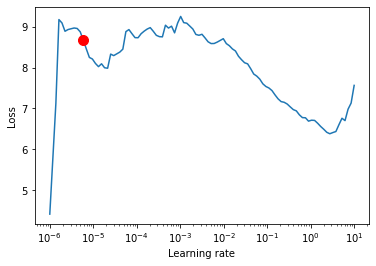

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=5.888436553555889e-06, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 75.2k


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1815: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [ ]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# can be stopped at any point -- did at 24 epochs
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Missing logger folder: lightning_logs/lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.0 K 
3  | prescalers                         | ModuleDict                      | 1.3 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 36.1 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 23.1 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
import pickle

In [ ]:




# can cancel, but wait after clicking -- take time to cancel
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100, #200,
    max_epochs=10,#50
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-05-17 19:17:26,884] A new study created in memory with name: no-name-474fd61c-0894-4a20-b0ab-c6257b575c79
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:172: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/loca

KeyError: ignored

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(1.7866)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

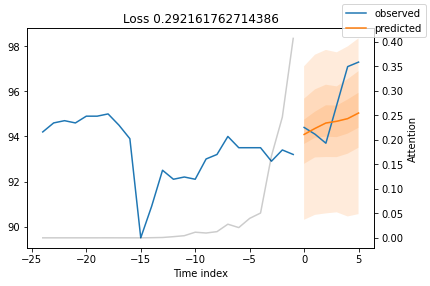

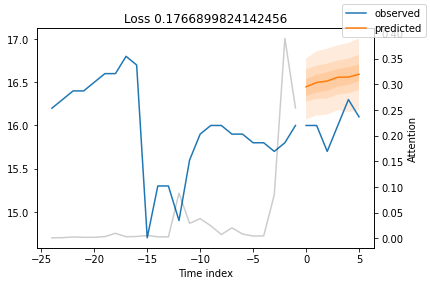

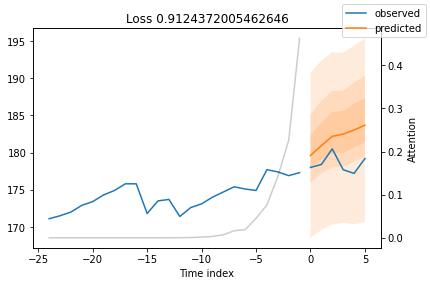

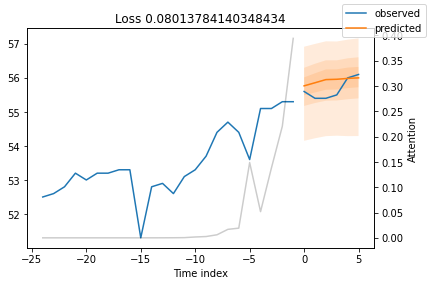

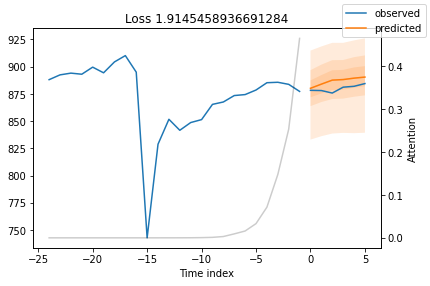

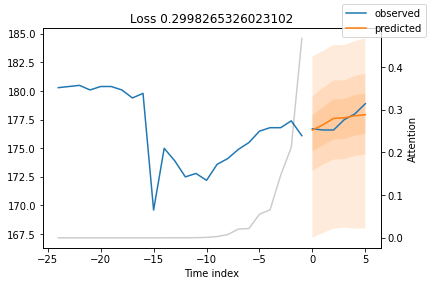

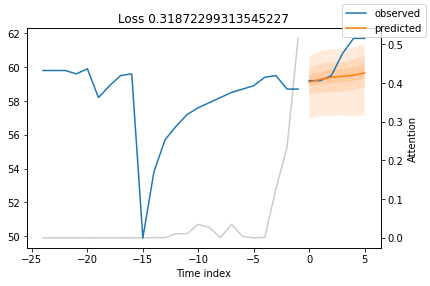

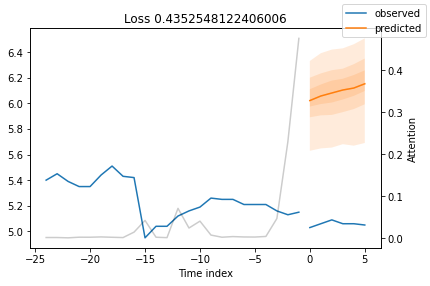

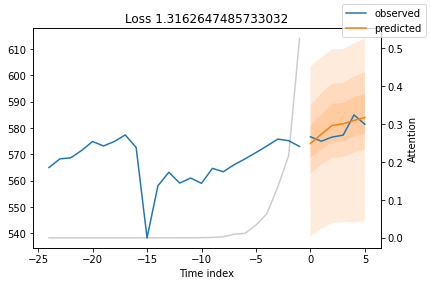

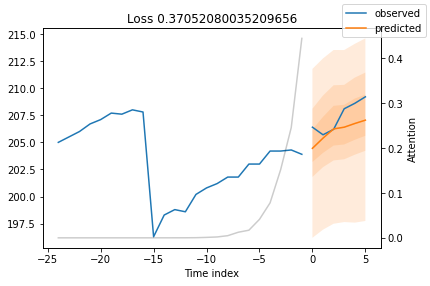

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

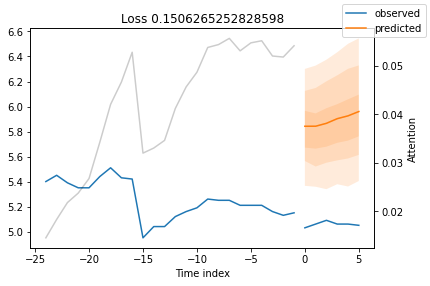

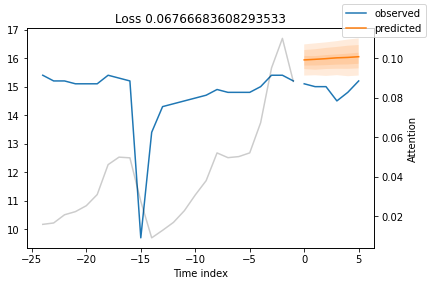

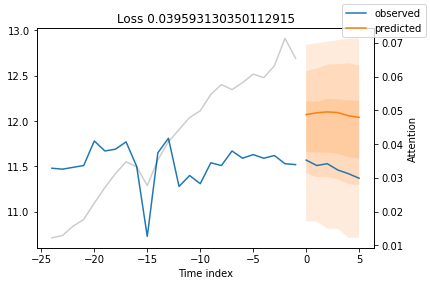

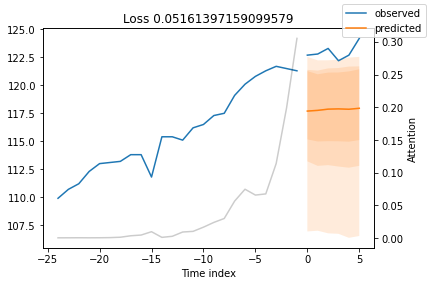

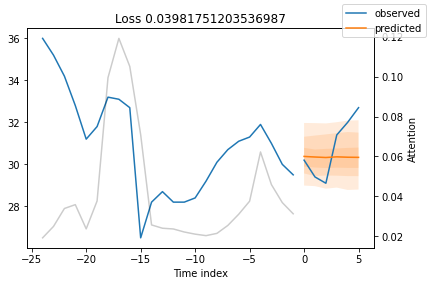

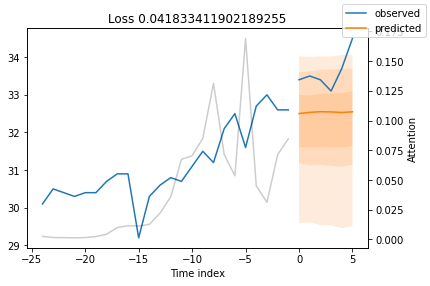

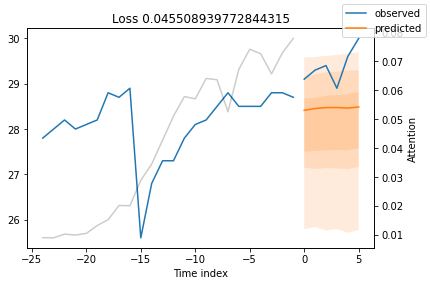

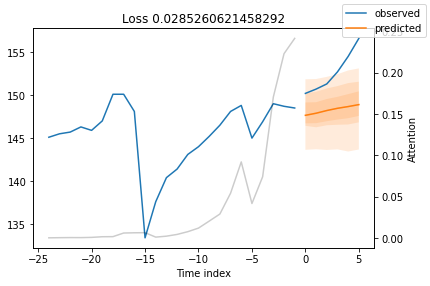

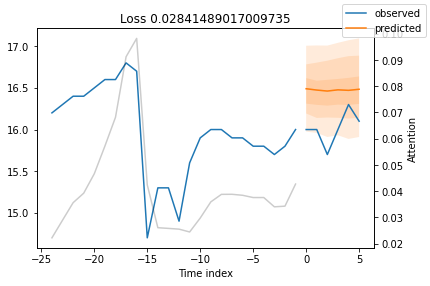

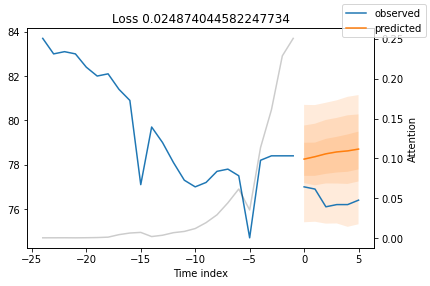

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.State == "Florida") & (x.time_idx_first_prediction == 190)),
    mode="quantiles",
)

tensor([[[452.7292, 476.5090, 484.0547, 488.2658, 494.8012, 502.6634, 515.7111],
         [454.0231, 479.4954, 487.5006, 491.7431, 499.1155, 507.8287, 520.9193],
         [454.5471, 479.0075, 487.8907, 494.1730, 501.0376, 508.4242, 521.6612],
         [456.8119, 480.6518, 489.0836, 496.8709, 503.7650, 511.0426, 523.0681],
         [458.7064, 483.8036, 492.0693, 500.0786, 506.9854, 514.7731, 527.4608],
         [458.7866, 485.0919, 493.8835, 501.5102, 509.2565, 516.5751, 529.2478]]])

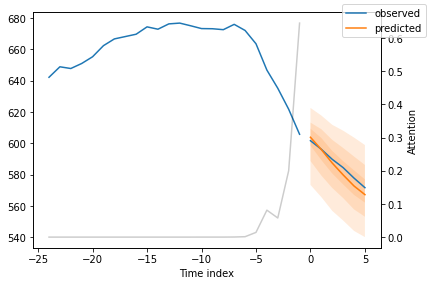

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.State == "Texas") & (x.time_idx_first_prediction == 100)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

In [ ]:
interpretation = best_tft.interpret_output(raw_prediction, reduction="sum")


{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x756 with 1 Axes>,
 'static_variables': <Figure size 504x1080 with 1 Axes>}

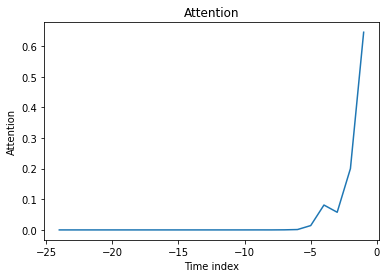

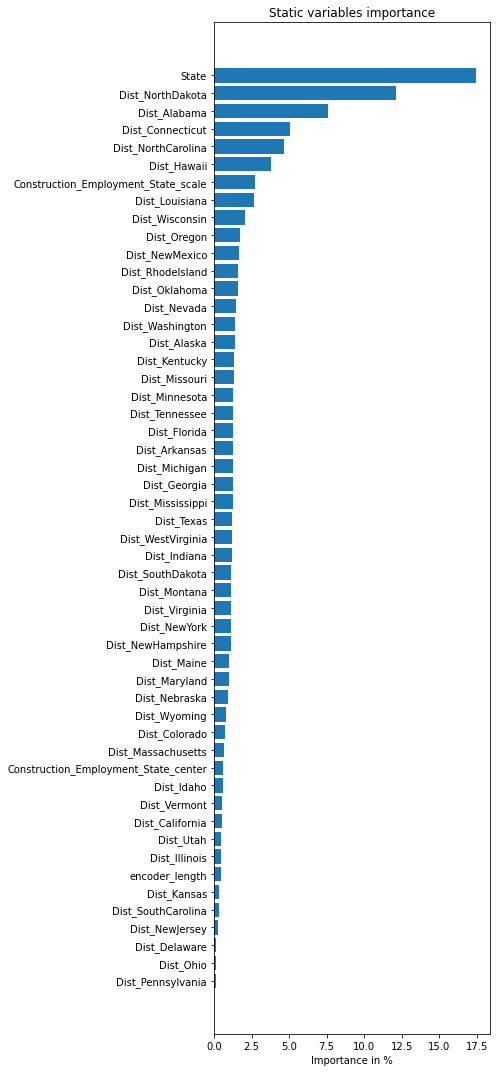

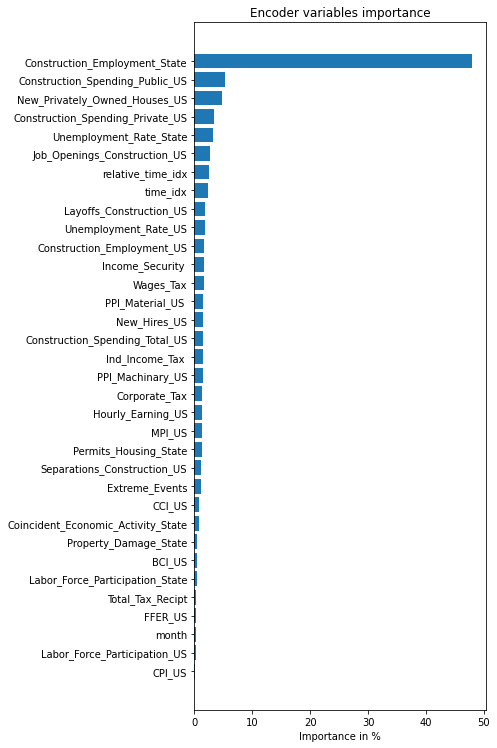

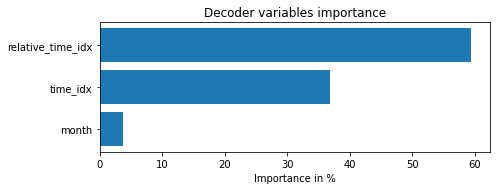

In [ ]:
best_tft.plot_interpretation(interpretation)


Predict on new data


In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["Date"].dt.year * 12 + decoder_data["Date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.Date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

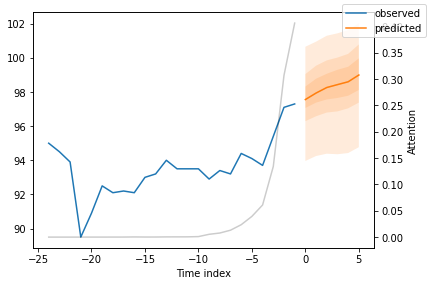

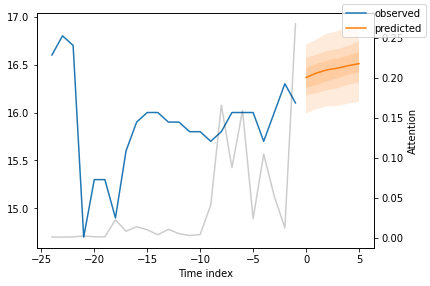

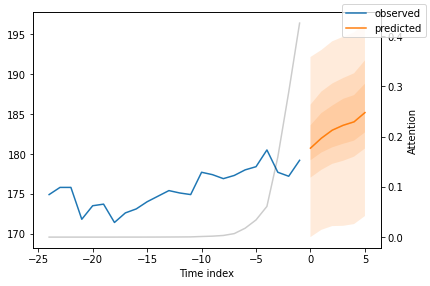

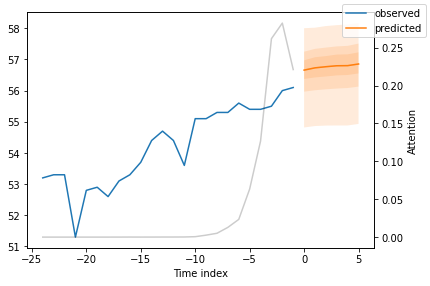

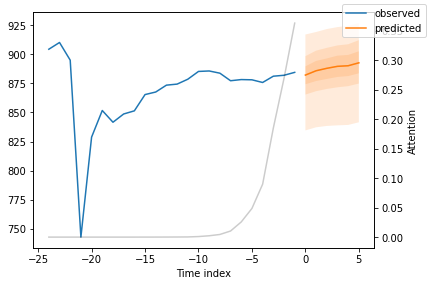

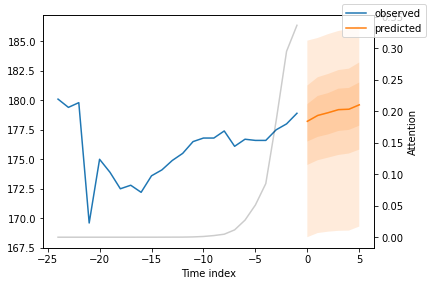

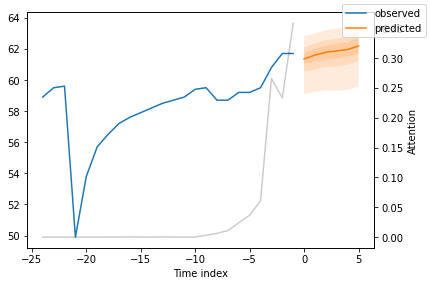

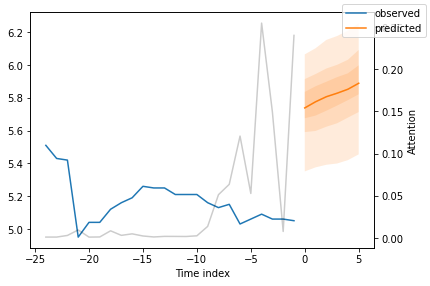

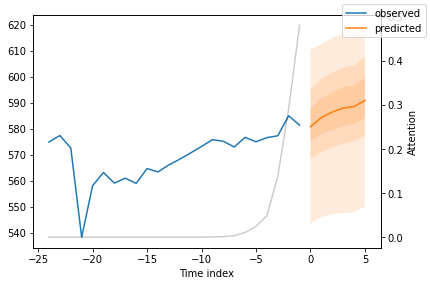

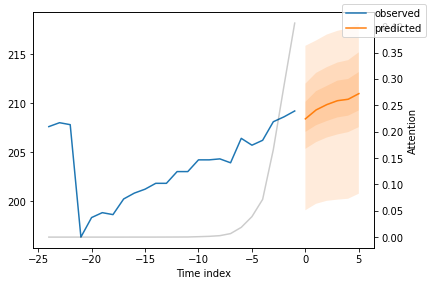

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);